## PyTorch 实现 自编码器

理论部分参考：[自编码器变形和变分自编码器理论介绍及其 PyTorch 实现](https://dreamhomes.github.io/posts/202006021200.html)

In [1]:
import os

import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision

from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


print(torch.__version__)

1.5.0


In [2]:
# 超参数
EPOCH = 10
BATCH_SIZE = 64
LR = 0.005
if os.path.exists('./data/mnist/'):  # 如果已经存在（下载）了就不用下载了
    DOWNLOAD_MNIST = False
else:
    DOWNLOAD_MNIST = True   # 下过数据的话, 就可以设置成 False
N_TEST_IMG = 5          # 到时候显示 5张图片看效果,

### Mnist数据

In [3]:
train_data = torchvision.datasets.MNIST(
    root='./data/mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

test_data = torchvision.datasets.MNIST(root='./data/mnist/', train=False)

# 批训练 64 samples, 1 channel, 28x28 (64, 1, 28, 28)
train_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

### 构造模型

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3),   # 进行 3D 图像可视化
        )
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # 激励函数让输出值在 (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    
autoencoder = AutoEncoder()

### 训练模型

In [5]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

for epoch in range(EPOCH):
    for step, (x, b_label) in enumerate(train_loader):
        b_x = x.view(-1, 28*28)   # batch x, shape (batch, 28*28)

        encoded_x, decoded_x = autoencoder(b_x)

        loss = loss_func(decoded_x, b_x) 
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step() 

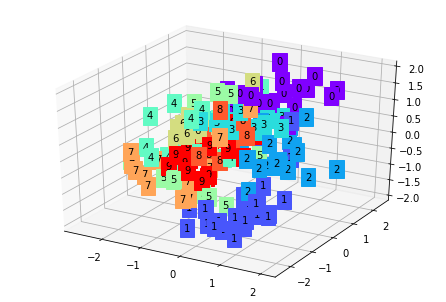

In [7]:
# 取200个数据来作图
view_data = train_data.data[:200].view(-1, 28 * 28).type(torch.FloatTensor) / 255.
encoded_data, _ = autoencoder(view_data)  # 提取压缩的特征值
fig = plt.figure(2)
ax = Axes3D(fig)  # 3D 图
# x, y, z 的数据值
X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy()
values = train_data.targets[:200].numpy()  # 标签值
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255 * s / 9))  # 上色
    ax.text(x, y, z, s, backgroundcolor=c)  # 标位子
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

### SVM 对压缩后的特征进行数字识别

In [19]:
# 取1000个训练数据来训练svm
svm_train = train_data.data[:1000].view(-1, 28 * 28).type(torch.FloatTensor) / 255.
s_t_x_afterencoder = autoencoder(svm_train)[0].data.numpy()
print(s_t_x_afterencoder.shape)
s_t_y = train_data.targets[:1000].numpy()  # 标签值
print(s_t_y.shape)
# 取1000个训练数据来测试
svm_test = test_data.data[:1000].view(-1, 28 * 28).type(torch.FloatTensor) / 255.
s_te_x_afterencoder = autoencoder(svm_test)[0].data.numpy()
s_te_y = test_data.targets[:1000].numpy()  # label

c_can = np.logspace(-3, 2, 10)
gamma_can = np.logspace(-3, 2, 10)

model = svm.SVC(kernel='rbf', decision_function_shape='ovr', random_state=1)
clf = GridSearchCV(model, param_grid={'C': c_can, 'gamma': gamma_can}, cv=5, n_jobs=5)
clf.fit(s_t_x_afterencoder, s_t_y)

print('test accuracy：\t', clf.score(s_te_x_afterencoder, s_te_y))  # 因为压缩到了三个特征，准确率并不是很高

(1000, 3)
(1000,)
test accuracy：	 0.799


In [24]:
clf.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': False,
 'estimator__random_state': 1,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(random_state=1),
 'iid': 'deprecated',
 'n_jobs': 5,
 'param_grid': {'C': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
         1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
         2.78255940e+01, 1.00000000e+02]),
  'gamma': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
         1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
         2.78255940e+01, 1.00000000e+02])},
 'pre_dispatch': '2*n_jobs',
 'refi

In [23]:
clf.best_params_

{'C': 0.5994842503189409, 'gamma': 2.1544346900318843}